<a href="https://colab.research.google.com/github/Shidomohd2/AI-or-REAL-image-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 🚀 Install Required Libraries
!pip install --upgrade kagglehub tensorflow scikit-learn tqdm

import kagglehub
import os
import numpy as np
from tqdm import tqdm  # Progress tracking
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import gc  # Garbage Collection
import tensorflow as tf

# ✅ Enable Mixed Precision for Faster Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Control GPU Memory Growth (85% Limit)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(0.85 * 15360))]  # 85% of 15 GB
            )
        print("✅ GPU Memory Growth Limited to 85%")
    except RuntimeError as e:
        print(e)

# ✅ Download dataset from Kaggle
dataset_path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Dataset downloaded to:", dataset_path)

# ✅ Define dataset directories
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

# ✅ Fix Image Size (MobileNetV2 uses 224x224)
img_size = (224, 224)
batch_size = 32

# ✅ Data Generators
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

# ✅ Load MobileNetV2 for Feature Extraction (Efficient and Lightweight)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze model

# ✅ Function to Extract Features Efficiently with GPU
def extract_features_in_batches(generator, dataset_name="Dataset"):
    features = []
    labels = []
    total_batches = len(generator)
    print(f"\n🔄 Extracting Features for {dataset_name}...")

    for _ in tqdm(range(total_batches), desc=f"🔄 {dataset_name} Batches"):
        # Get a batch of images and labels
        x_batch, y_batch = next(generator)

        # Convert batch to TensorFlow Dataset for optimized GPU processing
        x_batch = tf.convert_to_tensor(x_batch)

        # Extract features using MobileNetV2
        batch_features = base_model(x_batch, training=False)
        batch_features = tf.keras.layers.GlobalAveragePooling2D()(batch_features)
        batch_features = batch_features.numpy()  # Convert to NumPy

        # Store features and labels
        features.append(batch_features)
        labels.extend(y_batch)

        # Clear Memory
        del x_batch, y_batch, batch_features
        gc.collect()

    # Combine all batches
    features = np.vstack(features)
    labels = np.array(labels)
    return features, labels

# ✅ Extract Features for Training and Testing
train_features, train_labels = extract_features_in_batches(train_generator, dataset_name="Training")
test_features, test_labels = extract_features_in_batches(test_generator, dataset_name="Testing")

# ✅ Train Random Forest Classifier
print("\n🔄 Training Random Forest Classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_features, train_labels)
print("✅ Training Completed")

# ✅ Make Predictions
predictions = clf.predict(test_features)
print("\nClassification Report:\n", classification_report(test_labels, predictions))
print("\nAccuracy Score:", accuracy_score(test_labels, predictions))

# ✅ Save the Model
joblib.dump(clf, "cifake_rf_model.pkl")
print("\n✅ Random Forest Model saved as cifake_rf_model.pkl")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: kagglehub
    Found existing installation: kagglehub 0.3.7
    Uninstalling kagglehub-0.3.7:
      Successfully uninstalled kagglehub-0.3.7
✅ GPU Memory Growth Limited to 85%


100%|██████████| 105M/105M [00:05<00:00, 19.2MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🔄 Extracting Features for Training...


🔄 Training Batches: 100%|██████████| 3125/3125 [21:53<00:00,  2.38it/s]



🔄 Extracting Features for Testing...


🔄 Testing Batches: 100%|██████████| 625/625 [04:07<00:00,  2.53it/s]



🔄 Training Random Forest Classifier...
✅ Training Completed

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.89      0.88     10000
         1.0       0.89      0.86      0.87     10000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000


Accuracy Score: 0.8755

✅ Random Forest Model saved as cifake_rf_model.pkl


✅ Model loaded successfully!


Saving DALL·E 2024-11-26 08.13.24 - A conceptual illustration representing a diligent and creative student specializing in information systems and programming. The scene shows a young pe.webp to DALL·E 2024-11-26 08.13.24 - A conceptual illustration representing a diligent and creative student specializing in information systems and programming. The scene shows a young pe.webp

✅ Uploaded File: DALL·E 2024-11-26 08.13.24 - A conceptual illustration representing a diligent and creative student specializing in information systems and programming. The scene shows a young pe.webp


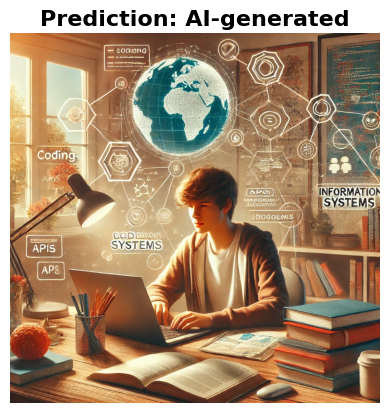


🔹 **Prediction Result:** AI-generated


17470

In [10]:
!pip install tensorflow joblib numpy pillow

import os
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import gc  # Garbage collection
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2

# ✅ Load the trained model correctly
model_path = "cifake_rf_model.pkl"

# Ensure model file exists before loading
if os.path.exists(model_path):
    with open(model_path, "rb") as f:
        model = joblib.load(f)
    print("✅ Model loaded successfully!")
else:
    print("❌ Model file not found! Retrain the model or upload 'cifake_rf_model.pkl'.")

# ✅ Load MobileNetV2 for Feature Extraction
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze model layers

# ✅ Function to Extract Features from Image
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for MobileNetV2

    features = base_model(img_array, training=False)  # Extract Features
    features = tf.keras.layers.GlobalAveragePooling2D()(features)  # Pooling
    return features.numpy()

# ✅ Upload Image in Google Colab
uploaded = files.upload()

if uploaded:
    # Get the first uploaded file
    filename = list(uploaded.keys())[0]
    print(f"\n✅ Uploaded File: {filename}")

    # Extract Features & Predict
    features = extract_features(filename)
    prediction = model.predict(features.reshape(1, -1))[0]
    result = "AI-generated" if prediction == 0 else "Real world image"

    # ✅ Show Image & Prediction Result
    img = image.load_img(filename)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {result}", fontsize=16, fontweight="bold")
    plt.show()

    print(f"\n🔹 **Prediction Result:** {result}")

# ✅ Clear Memory
gc.collect()
